# 1. Install Dependencies and Setup

In [1]:
import tensorflow as tf
import os
from tensorflow import*


In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [4]:
import cv2
import imghdr

In [5]:
data_dir = 'data' 

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

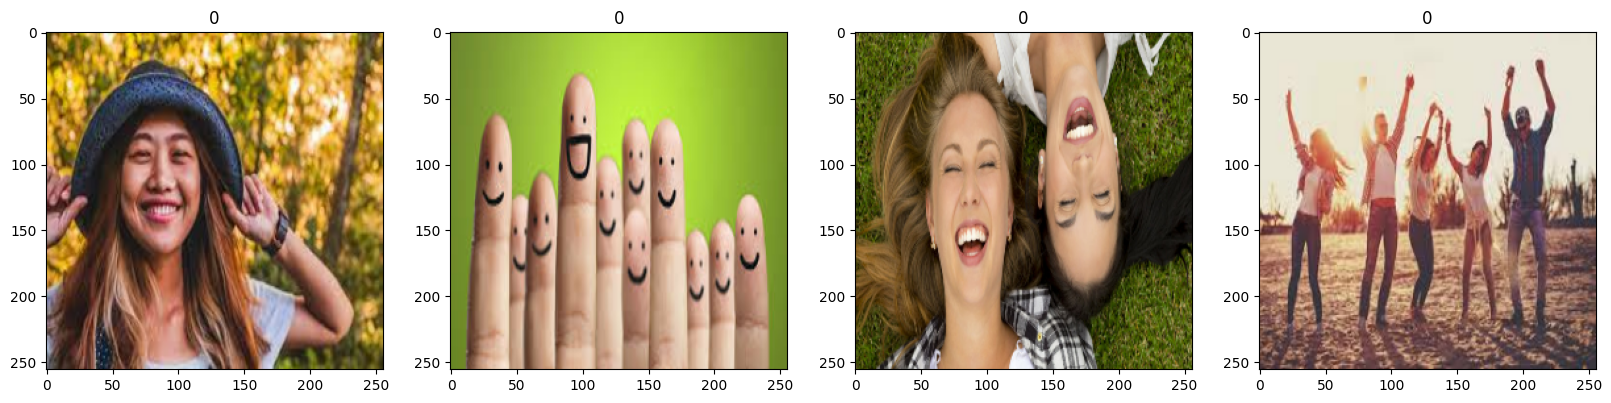

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [13]:
data = data.map(lambda x,y: (x/255, y))

In [14]:
data.as_numpy_iterator().next()

(array([[[[0.8435049 , 0.83958334, 0.82389706],
          [0.7693321 , 0.76541054, 0.74972427],
          [0.8151808 , 0.8112592 , 0.79557294],
          ...,
          [0.65580577, 0.6518842 , 0.6361979 ],
          [0.7868413 , 0.7829197 , 0.76723343],
          [0.7679075 , 0.76398593, 0.74829966]],
 
         [[0.81308246, 0.8091609 , 0.7934746 ],
          [0.7804075 , 0.7764859 , 0.76079965],
          [0.81432784, 0.81040627, 0.79472   ],
          ...,
          [0.6722369 , 0.66831535, 0.6526291 ],
          [0.7754287 , 0.77150714, 0.7558209 ],
          [0.7604225 , 0.75650096, 0.7408147 ]],
 
         [[0.77562505, 0.7717035 , 0.7560172 ],
          [0.79433244, 0.7904109 , 0.7747246 ],
          [0.81433153, 0.81040996, 0.7947237 ],
          ...,
          [0.68921304, 0.68529147, 0.6696052 ],
          [0.7567718 , 0.75285023, 0.73716396],
          [0.74962735, 0.7457058 , 0.7300195 ]],
 
         ...,
 
         [[0.9724193 , 0.96849775, 0.9528115 ],
          [0.94128

# 5. Split Data

In [15]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [16]:
train_size

7

In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [18]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [20]:
model = Sequential()

In [21]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [22]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# 7. Train

In [24]:
logdir='logs'

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20




7/7 [==============================] - 5s 411ms/step - loss: 1.0249 - accuracy: 0.4286 - val_loss: 0.6977 - val_accuracy: 0.5156
Epoch 2/20
7/7 [==============================] - 3s 381ms/step - loss: 0.6509 - accuracy: 0.6607 - val_loss: 0.5909 - val_accuracy: 0.6875
Epoch 3/20
7/7 [==============================] - 3s 379ms/step - loss: 0.5260 - accuracy: 0.7589 - val_loss: 0.4013 - val_accuracy: 0.8125
Epoch 4/20
7/7 [==============================] - 3s 378ms/step - loss: 0.4568 - accuracy: 0.7812 - val_loss: 0.3538 - val_accuracy: 0.9219
Epoch 5/20
7/7 [==============================] - 4s 414ms/step - loss: 0.3562 - accuracy: 0.8705 - val_loss: 0.3110 - val_accuracy: 0.8750
Epoch 6/20
7/7 [==============================] - 4s 404ms/step - loss: 0.3637 - accuracy: 0.8795 - val_loss: 0.5322 - val_accuracy: 0.7656
Epoch 7/20
7/7 [==============================] - 4s 405ms/step - loss: 0.3462 - accuracy: 0.8571 - val_loss: 0.3112 - val_accuracy: 0.9219
Epoch 8/20
7/7 [=============

# 8. Plot Performance

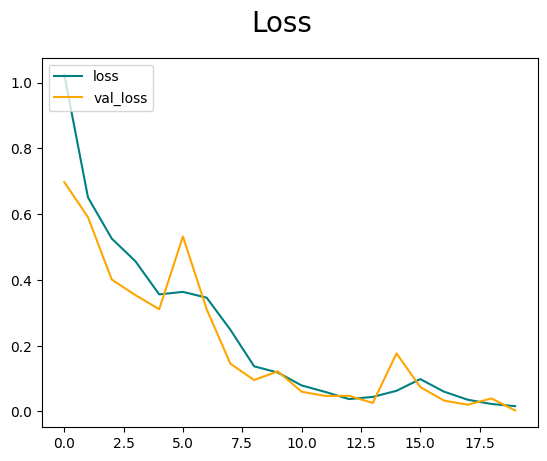

In [27]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

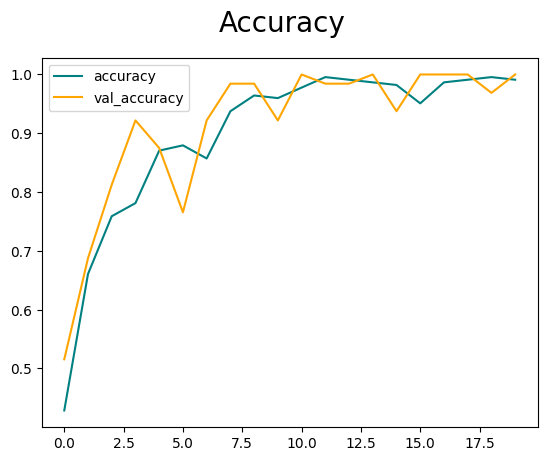

In [28]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [29]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [30]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [31]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 116ms/step


In [32]:
print(pre.result(), re.result(), acc.result())

1 1 1


# 10. Test

In [33]:
import cv2

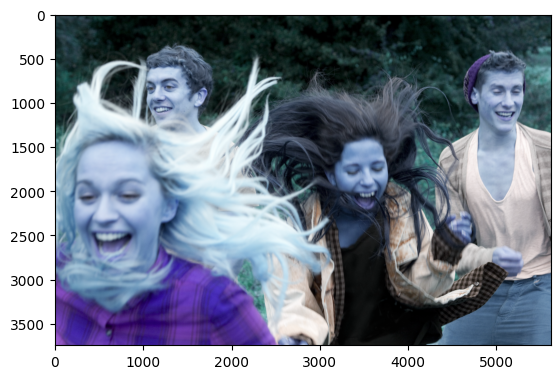

In [34]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

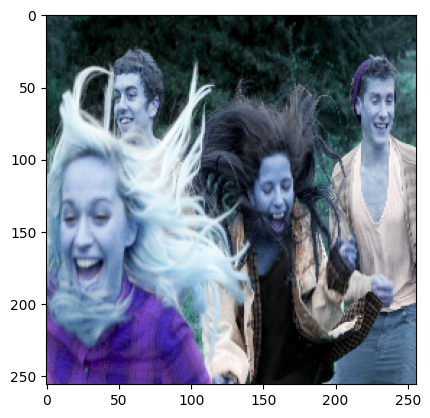

In [35]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [36]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 28ms/step


In [37]:
yhat

array([[0.00011805]], dtype=float32)

In [38]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [39]:
from tensorflow.keras.models import load_model

In [40]:
model.save('image-classifier.keras')

In [41]:
new_model = load_model('image-classifier.keras')

In [42]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 77ms/step


array([[0.00011805]], dtype=float32)

In [43]:
import tkinter as tk
import customtkinter
from tkinter import *
from tkinter.filedialog import askopenfilename
from PIL import Image, ImageTk
import cv2

   

In [44]:
customtkinter.set_appearance_mode('dark')
customtkinter.set_default_color_theme('dark-blue')

root = customtkinter.CTk()
root.geometry("1100x650")
root.title('Encryption & Decryption')

frame = customtkinter.CTkFrame(master=root)
frame.pack(pady=20, padx=60, fill='both', expand=True)


In [45]:
result = customtkinter.CTkTextbox(master= frame, width=300,height=70)
result.pack()
result.place(x=500,y=100) 


In [46]:
def classify_image():
    global image_data, photo, image_label,filename
    filename = askopenfilename()
    image_data = Image.open(filename)
    image_data = image_data.resize((300, 300))
    # Convert the image to a format that can be displayed in Tkinter
    photo = ImageTk.PhotoImage(image_data)
    
    # Create a frame to hold the image label
    image_frame = customtkinter.CTkFrame(master=root, width=300, height=300)
    image_frame.pack(side=LEFT, padx=10)
    image_frame.place(x=50,y=80)
    
    # Create a label to display the image
    image_label = Label(image_frame, image=photo)
    image_label.pack()
    
    label1 = customtkinter.CTkLabel(master=root,text="selected image" ,font=("Roboto",24) )
    label1.pack()
    label1.place(x=50,y=30)

    img2 = cv2.imread(filename)
    resize = tf.image.resize(img2, (256,256))
    yhat = model.predict(np.expand_dims(resize/255, 0))
    if yhat > 0.5: 
               result.delete('1.0','end') , result.insert('1.0','Predicted class is Sad')
    else:
         result.delete('1.0','end') ,result.insert('1.0','Predicted class is happy')
        

In [47]:


test_button = customtkinter.CTkButton(master= frame ,text='test Image', command=classify_image )
test_button.place(x=300,y=130)



In [48]:
root.mainloop()

1/1 [==============================] - 0s 25ms/step
